In [ ]:
import numpy as np
from scipy.signal import cont2discrete
import matplotlib.pyplot as plt

# ==============================
# Parámetros físicos y Modelo continuo
# ==============================
m_b = 250.0
m_w = 50.0
k_s = 16000.0
k_t = 190000.0
b_s = 1000.0
b_t = 0.0

A = np.array([
    [0, 1, 0, 0],
    [-k_s/m_b, -b_s/m_b, k_s/m_b, b_s/m_b],
    [0, 0, 0, 1],
    [k_s/m_w, b_s/m_w, -(k_s + k_t)/m_w, -(b_s + b_t)/m_w]
])

B = np.array([
    [0, 0],
    [0, 1/m_b],
    [0, 0],
    [k_t/m_w, 1/m_w]
])

C = np.array([
    [1, 0, 0, 0],
    [-k_s/m_b, -b_s/m_b, k_s/m_b, b_s/m_b],
    [1, 0, -1, 0]
])

D = np.array([
    [0, 0],
    [0, 1/m_b],
    [0, 0]
])

num_simulaciones = 20
Ts = 0.01
sistema_continuo = (A, B, C, D)
Ad, Bd, Cd, Dd, dt = cont2discrete(sistema_continuo, Ts, method='zoh')

T_sim = 20.0
N = int(T_sim / Ts)
t = np.linspace(0, T_sim, N)

# Número de estados y salidas
num_states = Ad.shape[0]
num_outputs = Cd.shape[0]

# Inicializa un arreglo 3D para TODAS las salidas: (simulaciones, muestras de tiempo, salidas)
y_all_simulations = np.zeros((num_simulaciones, N, num_outputs))
u_data_all = np.zeros((num_simulaciones, N))

bump_height_min, bump_height_max = 0.05, 0.2
bump_duration_min, bump_duration_max = 1.0, 3.0
t_bump_start = 2.0

for i in range(num_simulaciones):
    # 1. Variar los parámetros del bache
    bump_height = np.random.uniform(bump_height_min, bump_height_max)
    bump_duration = np.random.uniform(bump_duration_min, bump_duration_max)

    t_bump_end = t_bump_start + bump_duration

    # 2. Generar la señal de entrada (u_signal)
    u_signal = np.zeros((N, 2))
    idx_start = int(t_bump_start / Ts)
    idx_end = int(t_bump_end / Ts)

    if idx_end > N:
        idx_end = N

    t_bump = t[idx_start:idx_end] - t_bump_start
    bump = bump_height * 0.5 * (1 - np.cos(np.pi * (t_bump) / bump_duration))
    u_signal[idx_start:idx_end, 0] = bump
    # 3. Inicializar estados y salidas para la nueva simulación
    x = np.zeros((N, num_states))
    y = np.zeros((N, num_outputs))
    x_k = np.zeros(num_states)

    # 4. Bucle de simulación discreta
    for k in range(N - 1):
        u_k = u_signal[k, :]
        x_k_plus_1 = Ad @ x_k + Bd @ u_k
        y_k = Cd @ x_k + Dd @ u_k

        x[k+1, :] = x_k_plus_1
        # Almacenamos TODAS las salidas en esta iteración
        y_all_simulations[i, k, :] = y_k
        x_k = x_k_plus_1

    # 5. Almacenar la entrada (z_r)
    u_data_all[i, :] = u_signal[:, 0]

np.savez('datos_suspension.npz',
         y_all_simulations=y_all_simulations,
         u_data_all=u_data_all,
         t=t)

Semillas aleatorias fijadas en 42 para NumPy, PyTorch y Python.
0. Cargando datos y definiendo parámetros...
1. Estructurando datos en formato NARX MIMO...
2. Normalizando datos...
3. Definiendo la arquitectura NN-MIMO...
4. Iniciando entrenamiento de la NN-MIMO (Epochs: 150, LR: 0.001)...
Epoch [25/150], Loss: 0.000003
Epoch [50/150], Loss: 0.000002
Epoch [75/150], Loss: 0.000002
Epoch [100/150], Loss: 0.000002
Epoch [125/150], Loss: 0.000001
Epoch [150/150], Loss: 0.000001
Entrenamiento finalizado.

=== Métricas de Rendimiento del Modelo NN-MIMO ===

Salida 1 (y1 (Posición, m)):
  MAE: 4.3627e-04
  MSE: 2.1875e-07
  RMSE: 4.6771e-04
  Error Máximo: 4.7949e-03

Salida 2 (y2 (Aceleración, m/s^2)):
  MAE: 3.4574e-02
  MSE: 1.7626e-03
  RMSE: 4.1984e-02
  Error Máximo: 9.5263e-01

Salida 3 (y3 (Deflexión, m)):
  MAE: 2.2217e-04
  MSE: 5.3137e-08
  RMSE: 2.3052e-04
  Error Máximo: 1.9326e-03


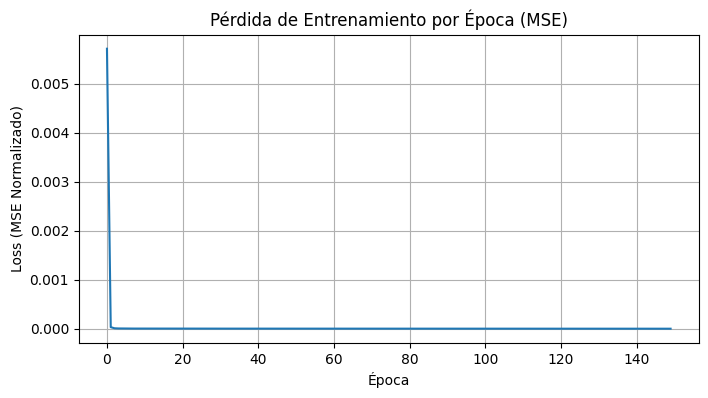

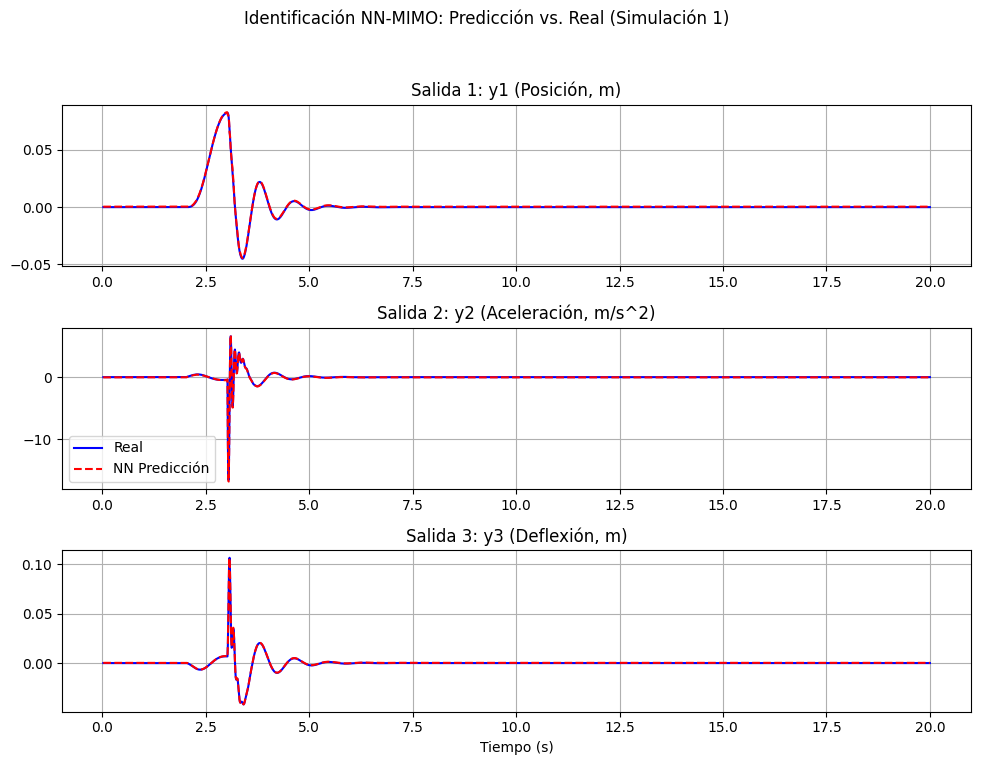

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import random

def set_seed(seed_value=42):
    # 1. Semilla para Python (core)
    random.seed(seed_value)

    # 2. Semilla para NumPy (generación de datos y manejo de arrays)
    np.random.seed(seed_value)

    # 3. Semilla para PyTorch (Inicialización de pesos del modelo y procesos)
    torch.manual_seed(seed_value)

set_seed(42)

print("Semillas aleatorias fijadas en 42 para NumPy, PyTorch y Python.")

# ====================================================================
# 0. Cargar los Datos Generados
# ====================================================================
print("0. Cargando datos y definiendo parámetros...")
data = np.load('datos_suspension.npz')
y_all_simulations = data['y_all_simulations']
u_data_all = data['u_data_all']
t = data['t']

num_simulaciones, N, num_outputs = y_all_simulations.shape
num_inputs_u = 1
Ts = t[1] - t[0]

# Parámetros NARX para el modelo MIMO
ny = 2 # Retardos de Salida (y_{i, k-1}, y_{i, k-2} para i=1,2,3)
nu = 2 # Retardos de Entrada (u_k, u_{k-1})
max_delay = max(ny, nu)
INPUT_SIZE = (num_outputs * ny) + nu
OUTPUT_SIZE = num_outputs

# ====================================================================
# 1. ESTRUCTURACIÓN DE DATOS NARX
# ====================================================================

print("1. Estructurando datos en formato NARX MIMO...")
N_rows = num_simulaciones * (N - max_delay)
X_train_raw = np.zeros((N_rows, INPUT_SIZE), dtype=np.float32)
Y_train_raw = np.zeros((N_rows, OUTPUT_SIZE), dtype=np.float32)

row_index = 0
for i in range(num_simulaciones):
    u_sim = u_data_all[i, :]
    y_sim = y_all_simulations[i, :, :]

    for k in range(max_delay, N):

        # 1. Componentes de la Entrada X
        x_row = []

        # a) Retardos de la Salida (y1, y2, y3)
        for output_idx in range(num_outputs):
            x_row.append(y_sim[k-1, output_idx]) # y_{i, k-1}
            x_row.append(y_sim[k-2, output_idx]) # y_{i, k-2}

        # b) Retardos de la Entrada (u)
        x_row.append(u_sim[k])   # u_k
        x_row.append(u_sim[k-1]) # u_{k-1}

        X_train_raw[row_index, :] = np.array(x_row)

        # 2. Componentes de la Salida Y (3 señales simultáneas)
        Y_train_raw[row_index, :] = y_sim[k, :] # [y_{1,k}, y_{2,k}, y_{3,k}]

        row_index += 1

# ====================================================================
# 2. NORMALIZACIÓN DE DATOS Y CONVERSIÓN A TENSORES
# ====================================================================

print("2. Normalizando datos...")

# Normalizador para las Entradas (X)
scaler_X = MinMaxScaler()
X_norm = scaler_X.fit_transform(X_train_raw)

# Normalizador para las Salidas (Y)
scaler_Y = MinMaxScaler()
Y_norm = scaler_Y.fit_transform(Y_train_raw)

# Convertir a Tensores de PyTorch
X_tensor = torch.tensor(X_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_norm, dtype=torch.float32)

# Crear DataLoader
batch_size = 128
dataset = TensorDataset(X_tensor, Y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ====================================================================
# 3. IMPLEMENTACIÓN DE LA ARQUITECTURA NN
# ====================================================================

print("3. Definiendo la arquitectura NN-MIMO...")

class NARX_MIMO_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NARX_MIMO_NN, self).__init__()

        # Capas Densas para capturar la no linealidad (8 entradas -> 128 -> 64 -> 3 salidas)
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size) # 3 salidas

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) # Capa de salida sin activación para regresión
        return x

nn_model = NARX_MIMO_NN(INPUT_SIZE, OUTPUT_SIZE)

# ====================================================================
# 4. ENTRENAMIENTO DEL MODELO
# ====================================================================

num_epochs = 150
learning_rate = 0.001
criterion = nn.MSELoss() # Función de pérdida: Error Cuadrático Medio
optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

print(f"4. Iniciando entrenamiento de la NN-MIMO (Epochs: {num_epochs}, LR: {learning_rate})...")
train_loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in data_loader:

        # Paso 1: Forward Pass
        outputs = nn_model(inputs)

        # Paso 2: Calcular Pérdida
        loss = criterion(outputs, targets)

        # Paso 3: Backward Pass y Optimización
        optimizer.zero_grad() # Reiniciar gradientes
        loss.backward()       # Calcular gradientes
        optimizer.step()      # Actualizar pesos

        epoch_loss += loss.item() * inputs.size(0)

    avg_epoch_loss = epoch_loss / len(dataset)
    train_loss_history.append(avg_epoch_loss)

    if (epoch + 1) % 25 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.6f}")

print("Entrenamiento finalizado.")

# ====================================================================
# 5. EVALUACIÓN Y CÁLCULO DE MÉTRICAS
# ====================================================================

# Predicción en el conjunto de entrenamiento normalizado
nn_model.eval()
with torch.no_grad():
    Y_pred_norm = nn_model(X_tensor).numpy()

# Desnormalizar la predicción
Y_pred_raw = scaler_Y.inverse_transform(Y_pred_norm)

# Calcular el error
e = Y_train_raw - Y_pred_raw

results = {}
output_labels = ['y1 (Posición, m)', 'y2 (Aceleración, m/s^2)', 'y3 (Deflexión, m)']

print("\n=== Métricas de Rendimiento del Modelo NN-MIMO ===")
for i in range(OUTPUT_SIZE):
    e_i = e[:, i]
    MAE = np.mean(np.abs(e_i))
    MSE = np.mean(e_i**2)
    RMSE = np.sqrt(MSE)
    ErrorMax = np.max(np.abs(e_i))

    results[output_labels[i]] = {'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'ErrorMax': ErrorMax}

    print(f"\nSalida {i+1} ({output_labels[i]}):")
    print(f"  MAE: {MAE:.4e}")
    print(f"  MSE: {MSE:.4e}")
    print(f"  RMSE: {RMSE:.4e}")
    print(f"  Error Máximo: {ErrorMax:.4e}")

# ====================================================================
# 6. VISUALIZACIÓN
# ====================================================================

# Gráfica de error de entrenamiento
plt.figure(figsize=(8, 4))
plt.plot(train_loss_history)
plt.title('Pérdida de Entrenamiento por Época (MSE)')
plt.xlabel('Época')
plt.ylabel('Loss (MSE Normalizado)')
plt.grid(True)
plt.show()

# Gráfica de Comparación de las 3 Salidas (Simulación 1 de ejemplo)
sim_plot = 0
start_idx = sim_plot * (N - max_delay)
end_idx = (sim_plot + 1) * (N - max_delay)
t_plot = t[max_delay : N]

plt.figure(figsize=(10, 8))
plt.suptitle('Identificación NN-MIMO: Predicción vs. Real (Simulación 1)')

for i in range(num_outputs):
    plt.subplot(3, 1, i + 1)

    # Valores Reales (Simulación 0)
    y_real_plot = Y_train_raw[start_idx:end_idx, i]

    # Valores Predichos (Simulación 0)
    y_pred_plot = Y_pred_raw[start_idx:end_idx, i]

    plt.plot(t_plot, y_real_plot, 'b', label='Real')
    plt.plot(t_plot, y_pred_plot, 'r--', label='NN Predicción')
    plt.title(f'Salida {i+1}: {output_labels[i]}')
    plt.grid(True)
    if i == num_outputs - 1:
        plt.xlabel('Tiempo (s)')
    if i == 1:
        plt.legend(loc='best')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()